#### Prepared for Gabor's Data Analysis

# Data Analysis for Business, Economics, and Policy
by Gabor Bekes and  Gabor Kezdi
 
Cambridge University Press 2021

**[gabors-data-analysis.com ](https://gabors-data-analysis.com/)**

 License: Free to share, modify and use for educational purposes. 
 Not to be used for commercial purposes.

# Chapter 17

## Predicting firm exit

In [1]:
### SETTING UP DIRECTORIES

# import packages
import pandas as pd
import os
import numpy as np
import sys
import warnings
from pathlib import Path
import patsy

from mizani.formatters import percent_format
from plotnine import *
from datetime import datetime
import statsmodels.api as sm
import statsmodels.formula.api as smf
from mizani import transforms
from scipy.stats import norm
from IPython.core.display import HTML
from stargazer.stargazer import Stargazer
import statsmodels.nonparametric.kernel_regression as loess
import seaborn as sns
from mizani.formatters import percent_format
import regex as re
from sklearn.preprocessing import MultiLabelBinarizer, StandardScaler
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression, LogisticRegression, LogisticRegressionCV
from sklearn.model_selection import train_test_split, GridSearchCV, KFold
import sklearn.metrics as metrics
from sklearn.metrics import brier_score_loss, roc_curve, auc, confusion_matrix, roc_auc_score, mean_squared_error
from sklearn.ensemble import RandomForestClassifier

warnings.filterwarnings("ignore")

# set working directory for da_data_repo -- replace the
os.chdir('C:\\Users\\77774\\Documents\\GitHub\\Prediction_with_ML_for_Economists\\Assignment_3_finding_fast_growing_firms')

# location folders
data_in = "C:\\Users\\77774\\Documents\\GitHub\\Prediction_with_ML_for_Economists\\Assignment_3_finding_fast_growing_firms\\raw\\"
data_out = "C:\\Users\\77774\\Documents\\GitHub\\Prediction_with_ML_for_Economists\\Assignment_3_finding_fast_growing_firms\\clean\\"
results = "C:\\Users\\77774\\Documents\\GitHub\\Prediction_with_ML_for_Economists\\Assignment_3_finding_fast_growing_firms\\results\\"
func = 'C:\\Users\\77774\\Documents\\GitHub\\Prediction_with_ML_for_Economists\\Assignment_3_finding_fast_growing_firms\\'

sys.path.append(func)
from py_helper_functions import *

In [88]:
# Current script folder
path = os.getcwd()
base_dir = path.split("da_case_studies")[0]

#Set the location of your data directory
data_dir = base_dir + 'da_data_repo'

In [89]:
# location folders
data_in = os.path.join(data_dir, 'bisnode-firms/clean/')
data_out = os.path.join(data_dir, 'bisnode-firms/')
output = os.path.join(data_out, 'output/')
func = os.path.join(base_dir, 'da_case_studies/ch00-tech-prep/')
sys.path.append(func)

In [90]:
# Import the prewritten helper functions
from py_helper_functions import *

## Import data

In [8]:
current_csv_path = os.path.join(data_out,"bisnode_firms_clean.csv")
data = pd.read_csv(current_csv_path)

In [9]:
data.isnull().sum()

year                          0
comp_id                       0
begin                         0
end                           0
amort                         0
                             ..
sales_mil_log_sq              0
flag_low_d1_sales_mil_log     0
flag_high_d1_sales_mil_log    0
d1_sales_mil_log_mod          0
d1_sales_mil_log_mod_sq       0
Length: 118, dtype: int64

In [10]:
data.head()

,year,comp_id,begin,end,amort,curr_assets,curr_liab,extra_exp,extra_inc,extra_profit_loss,...,flag_miss_ceo_age,ceo_young,labor_avg_mod,flag_miss_labor_avg,default_f,sales_mil_log_sq,flag_low_d1_sales_mil_log,flag_high_d1_sales_mil_log,d1_sales_mil_log_mod,d1_sales_mil_log_mod_sq
0,2012,1001541.0,2012-01-01,2012-12-31,481.481476,9629.629883,1303.703735,0.0,0.000000,0.000000,...,0,1,0.621691,1,no_default,45.190017,1,0,-1.500000,2.250000
1,2012,1002029.0,2012-01-01,2012-12-31,14929.629883,203885.187500,120444.453125,0.0,0.000000,0.000000,...,0,1,0.458333,0,no_default,0.016375,0,0,0.684448,0.468469
2,2012,1003200.0,2012-01-01,2012-12-31,25.925926,22.222221,10996.295898,0.0,0.000000,0.000000,...,1,0,0.621691,1,default,34.614876,0,0,-1.424773,2.029978
3,2012,1011889.0,2012-01-01,2012-12-31,36625.925781,160166.671875,18911.111328,0.0,0.000000,0.000000,...,0,0,1.621212,0,no_default,0.698025,0,0,0.097722,0.009550
4,2012,1014183.0,2012-01-01,2012-12-31,12551.851562,199903.703125,8274.074219,0.0,7.407407,7.407407,...,0,0,0.715278,0,no_default,4.171000,0,0,-0.273087,0.074577


## Define helper functions

In [11]:
def regression_results(y_true, y_pred):

    # Regression metrics
    explained_variance=metrics.explained_variance_score(y_true, y_pred)
    mean_absolute_error=metrics.mean_absolute_error(y_true, y_pred) 
    mse=metrics.mean_squared_error(y_true, y_pred) 
    median_absolute_error=metrics.median_absolute_error(y_true, y_pred)
    r2=metrics.r2_score(y_true, y_pred)

    print('explained_variance: ', round(explained_variance,4))    
    print('r2: ', round(r2,4))
    print('MAE: ', round(mean_absolute_error,4))
    print('MSE: ', round(mse,4))
    print('RMSE: ', round(np.sqrt(mse),4))
    
def coef_matrix(X, model):

    coef_matrix = pd.concat([pd.DataFrame(X.columns),pd.DataFrame(np.transpose(model.coef_))], axis = 1)
    coef_matrix.columns = ['variable', 'coefficient']
    coef_matrix = coef_matrix.append({'variable': 'Intercept', 'coefficient': np.asscalar(model.intercept_)}, ignore_index=True)
    return(coef_matrix)

def cv_summary(lambdas, C_values, model):
    d = {'lambdas': lambdas, 'C_values': C_values, 'mean_cv_score': model.scores_[1].mean(axis = 0)}
    return(pd.DataFrame(data=d))

def create_roc_plot(y_true, y_pred):
    fpr, tpr, thresholds = roc_curve(y_true, y_pred)
    all_coords = pd.DataFrame({
        'fpr': fpr,
        'tpr': tpr,
        'thresholds': thresholds
    })
    
    plot = ggplot(all_coords, aes(x = 'fpr', y = 'tpr')) \
        + geom_line(color=color[0], size = 0.7) \
        + geom_area(position = 'identity', fill = 'mediumaquamarine', alpha = 0.3) \
        + xlab("False Positive Rate (1-Specifity)") \
        + ylab("True Positive Rate (Sensitivity)") \
        + geom_abline(intercept = 0, slope = 1,  linetype = "dotted", color = "black") \
        + scale_y_continuous(limits = (0, 1), breaks = seq(0, 1, .1), expand = (0, 0.01)) \
        + scale_x_continuous(limits = (0, 1), breaks = seq(0, 1, .1), expand = (0.01, 0)) \
        + theme_bw()
    return(plot)

def sigmoid_array(x):
    return(1 / (1 + np.exp(-x)))

def generate_fold_prediction(model, X, fold, param_index):
    fold_coef = model.coefs_paths_[1][fold,param_index,:]
    return(sigmoid_array(np.dot(X, np.transpose(fold_coef)[:-1]) +  np.transpose(fold_coef)[-1]))

def create_loss_plot(all_coords, optimal_threshold, curr_exp_loss):
    all_coords_copy = all_coords.copy()
    all_coords_copy['loss'] = (all_coords_copy.false_pos*FP + all_coords_copy.false_neg*FN)/all_coords_copy.n
    
    t = optimal_threshold
    l = curr_exp_loss
    
    plot = ggplot(all_coords_copy, aes(x = 'thresholds', y = 'loss')) + \
        geom_line(color=color[0], size=0.7) + \
        scale_x_continuous(breaks = seq(0, 1.1, by = 0.1)) + \
        coord_cartesian(xlim=(0,1))+ \
        geom_vline(xintercept = t , color = color[0] ) + \
        annotate(geom = "text", x = t - 0.01, y= max(all_coords_copy.loss) - 0.4,
                 label="best threshold: " + str(round(t,2)),
                 colour=color[1], angle=90, size = 7) +\
        annotate(geom = "text", x = t + 0.06, y= l,\
                 label= str(round(l, 2)), size = 7) +\
        theme_bw()
    return(plot)


def create_roc_plot_with_optimal(all_coords, optimal_threshold):
    all_coords_copy = all_coords.copy()
    all_coords_copy['sp'] = all_coords_copy.true_neg/all_coords_copy.neg
    all_coords_copy['se'] = all_coords_copy.true_pos/all_coords_copy.pos
    
    best_coords = all_coords_copy[all_coords_copy.thresholds == optimal_threshold]
    sp = best_coords.sp.values[0]
    se = best_coords.se.values[0]

    plot = ggplot(all_coords_copy, aes(x = 'sp', y = 'se')) +\
        geom_line(color=color[0], size=0.7) +\
        scale_y_continuous(breaks = seq(0, 1.1, by = 0.1)) +\
        scale_x_reverse(breaks = seq(0, 1.1, by = 0.1)) +\
        geom_point(data = pd.DataFrame({'sp': [sp], 'se': [se]})) +\
        annotate(geom = "text", x = sp, y = se + 0.03,
                 label = str(round(sp, 2)) + ', ' + str(round(se, 2)), size = 7) +\
        theme_bw()
    return(plot)

## Define variable sets 

In [12]:
rawvars = ["curr_assets", "curr_liab", "extra_exp", "extra_inc", "extra_profit_loss", "fixed_assets",
              "inc_bef_tax", "intang_assets", "inventories", "liq_assets", "material_exp", "personnel_exp",
              "profit_loss_year", "sales", "share_eq", "subscribed_cap"]
qualityvars = ["balsheet_flag", "balsheet_length", "balsheet_notfullyear"]
engvar = ["total_assets_bs", "fixed_assets_bs", "liq_assets_bs", "curr_assets_bs",
            "share_eq_bs", "subscribed_cap_bs", "intang_assets_bs", "extra_exp_pl",
            "extra_inc_pl", "extra_profit_loss_pl", "inc_bef_tax_pl", "inventories_pl",
            "material_exp_pl", "profit_loss_year_pl", "personnel_exp_pl"]
engvar2 = ["extra_profit_loss_pl_quad", "inc_bef_tax_pl_quad",
             "profit_loss_year_pl_quad", "share_eq_bs_quad"]
engvar3=[]
for col in data.columns:
    if col.endswith('flag_low') or col.endswith('flag_high') or col.endswith('flag_error') or col.endswith('flag_zero'):
        engvar3.append(col)


d1 =  ["d1_sales_mil_log_mod", "d1_sales_mil_log_mod_sq",
         "flag_low_d1_sales_mil_log", "flag_high_d1_sales_mil_log"]
hr = ["female", "ceo_age", "flag_high_ceo_age", "flag_low_ceo_age",
        "flag_miss_ceo_age", "ceo_count", "labor_avg_mod",
        "flag_miss_labor_avg", "foreign_management"]

In [13]:
#Creat dummy columns from category variables and drop first level
ind2_catmat = patsy.dmatrix("0 + C(ind2_cat)",data, return_type="dataframe")
ind2_catmat = ind2_catmat.drop(['C(ind2_cat)[26.0]'], axis=1)

m_region_locmat = patsy.dmatrix("0 + C(m_region_loc)",data, return_type="dataframe")
m_region_locmat = m_region_locmat.drop(['C(m_region_loc)[Central]'], axis=1)

urban_mmat = patsy.dmatrix("0 + C(urban_m)",data, return_type="dataframe")
urban_mmat = urban_mmat.drop(['C(urban_m)[1.0]'], axis=1)

In [14]:
# Define X1
basevars = data[["sales_mil_log", "sales_mil_log_sq", "d1_sales_mil_log_mod", "profit_loss_year_pl"]]
X1 = pd.concat([basevars, ind2_catmat], axis=1)
# Define X2
X2additional_vars = data[["fixed_assets_bs", "share_eq_bs","curr_liab_bs", "curr_liab_bs_flag_high", \
                          "curr_liab_bs_flag_error",  "age", "foreign_management"]]
X2 = pd.concat([X1, X2additional_vars], axis=1)
# Define X3
firm = pd.concat([data[["age", "age2", "new"]], ind2_catmat, m_region_locmat, urban_mmat], axis=1)
X3 = pd.concat([data[["sales_mil_log", "sales_mil_log_sq"] + engvar + d1], firm], axis=1)
# Define X4
X4 = pd.concat([data[["sales_mil_log", "sales_mil_log_sq"] + engvar + d1 \
                                 + engvar2 + engvar3 + hr + qualityvars], firm], axis=1)

In [15]:
# Define X5
#Creat matrix for interactions1 variables
int1mat = patsy.dmatrix("0 + C(ind2_cat):age + C(ind2_cat):age2 + C(ind2_cat):d1_sales_mil_log_mod \
                + C(ind2_cat):sales_mil_log + C(ind2_cat):ceo_age + C(ind2_cat):foreign_management \
                + C(ind2_cat):female + C(ind2_cat):C(urban_m) + C(ind2_cat):labor_avg_mod", data, return_type="dataframe")
#Drop first level to get k-1 dummies out of k categorical levels 
for col in int1mat.columns:
    if col.startswith('C(ind2_cat)[26.0]') or col.endswith('C(urban_m)[1.0]'):
        int1mat = int1mat.drop([col], axis=1)
        
#Creat matrix for interactions2 variables        
int2mat = patsy.dmatrix("0 + sales_mil_log:age + sales_mil_log:female + sales_mil_log:profit_loss_year_pl \
                + sales_mil_log:foreign_management", data, return_type="dataframe")
X5 = pd.concat([X4, int1mat, int2mat], axis=1)

In [16]:
# Define logitvars for LASSO
logitvars = pd.concat([X4, int1mat, int2mat], axis=1)

In [17]:
# Define rfvars for RF (no interactions, no modified features)
rfvars  = pd.concat([data[["sales_mil", "d1_sales_mil_log"] + rawvars + hr + qualityvars], firm], axis=1)

In [18]:
y = data['default']

## Check simple linear and logistic models

In [19]:
# Check simplest model X1
ols_modelx1 = LinearRegression().fit(X1, y)

In [20]:
regression_results(y, ols_modelx1.predict(X1))

explained_variance:  0.1204
r2:  0.1204
MAE:  0.2852
MSE:  0.1419
RMSE:  0.3766


In [21]:
coef_matrix(X1, ols_modelx1)

,variable,coefficient
0,sales_mil_log,-0.007481
1,sales_mil_log_sq,0.005824
2,d1_sales_mil_log_mod,-0.056779
3,profit_loss_year_pl,-0.169230
4,C(ind2_cat)[27.0],0.019950
5,C(ind2_cat)[28.0],0.012457
6,C(ind2_cat)[29.0],0.049450
7,C(ind2_cat)[30.0],0.001055
8,C(ind2_cat)[33.0],0.001636
9,C(ind2_cat)[55.0],-0.004769


In [22]:
glm_modelx1 = LogisticRegression(solver="newton-cg",max_iter=1000, penalty="none").fit(X1, y)
regression_results(y, glm_modelx1.predict(X1))

explained_variance:  -0.0601
r2:  -0.1993
MAE:  0.1934
MSE:  0.1934
RMSE:  0.4398


In [23]:
coef_matrix(X1, glm_modelx1)

,variable,coefficient
0,sales_mil_log,-0.323186
1,sales_mil_log_sq,-0.001676
2,d1_sales_mil_log_mod,-0.366168
3,profit_loss_year_pl,-0.858115
4,C(ind2_cat)[27.0],0.168237
5,C(ind2_cat)[28.0],0.066165
6,C(ind2_cat)[29.0],0.515959
7,C(ind2_cat)[30.0],0.017364
8,C(ind2_cat)[33.0],-0.002646
9,C(ind2_cat)[55.0],0.039307


In [24]:
# Check model X2
glm_modelx2 = LogisticRegression(solver="newton-cg", max_iter=1000, penalty="none").fit(X2, y)
regression_results(y, glm_modelx2.predict(X2))

explained_variance:  -0.0527
r2:  -0.1592
MAE:  0.187
MSE:  0.187
RMSE:  0.4324


In [25]:
coef_matrix(X2, glm_modelx2)

,variable,coefficient
0,sales_mil_log,-0.180309
1,sales_mil_log_sq,0.015300
2,d1_sales_mil_log_mod,-0.482108
3,profit_loss_year_pl,-0.450082
4,C(ind2_cat)[27.0],0.145493
5,C(ind2_cat)[28.0],0.032691
6,C(ind2_cat)[29.0],0.406298
7,C(ind2_cat)[30.0],-0.033016
8,C(ind2_cat)[33.0],-0.157820
9,C(ind2_cat)[55.0],0.128747


In [26]:
mx2 = sm.Logit(y,sm.add_constant(X2)).fit().get_margeff()
mx2.summary()

Optimization terminated successfully.
         Current function value: 0.423258
         Iterations 7


<class 'statsmodels.iolib.summary.Summary'>
"""
        Logit Marginal Effects       
=====================================
Dep. Variable:                default
Method:                          dydx
At:                           overall
===========================================================================================
                             dy/dx    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------------------
sales_mil_log              -0.0242      0.006     -4.015      0.000      -0.036      -0.012
sales_mil_log_sq            0.0021      0.001      2.464      0.014       0.000       0.004
d1_sales_mil_log_mod       -0.0646      0.005    -12.868      0.000      -0.074      -0.055
profit_loss_year_pl        -0.0603      0.008     -7.740      0.000      -0.076      -0.045
C(ind2_cat)[27.0]           0.0195      0.024      0.829      0.407      -0.027       0.066
C(ind2_cat)[28.0]           0.0044      0.018      0.238      0.812      -0.032       0.040
C(ind2_cat)[29.0]           0.0545      0.030      1.816      0.069      -0.004       0.113
C(ind2_cat)[30.0]          -0.0044      0.039     -0.113      0.910      -0.082       0.073
C(ind2_cat)[33.0]          -0.0212      0.018     -1.161      0.245      -0.057       0.015
C(ind2_cat)[55.0]           0.0173      0.018      0.985      0.324      -0.017       0.052
C(ind2_cat)[56.0]           0.0622      0.015      4.068      0.000       0.032       0.092
fixed_assets_bs            -0.1087      0.008    -12.793      0.000      -0.125      -0.092
share_eq_bs                -0.0520      0.006     -8.414      0.000      -0.064      -0.040
curr_liab_bs                0.0229      0.012      1.865      0.062      -0.001       0.047
curr_liab_bs_flag_high      0.0181      0.010      1.812      0.070      -0.001       0.038
curr_liab_bs_flag_error     0.0426      0.115      0.370      0.711      -0.183       0.269
age                        -0.0047      0.000    -10.545      0.000      -0.006      -0.004
foreign_management          0.0290      0.009      3.182      0.001       0.011       0.047
===========================================================================================
"""

In [27]:
# baseline model is X4 (all vars, but no interactions) -------------------------------------------------------
ols_model = LinearRegression().fit(X4, y)
regression_results(y, ols_model.predict(X4))

explained_variance:  0.1924
r2:  0.1924
MAE:  0.2646
MSE:  0.1303
RMSE:  0.3609


In [28]:
coef_matrix(X4, ols_model)

,variable,coefficient
0,sales_mil_log,3.937242e-03
1,sales_mil_log_sq,3.264151e-03
2,total_assets_bs,5.475822e-10
3,fixed_assets_bs,-1.360564e-01
4,liq_assets_bs,-1.602016e-02
...,...,...
75,C(m_region_loc)[East],1.015797e-02
76,C(m_region_loc)[West],-1.783071e-02
77,C(urban_m)[2.0],8.293544e-03
78,C(urban_m)[3.0],-9.986761e-04


In [29]:
glm_model = LogisticRegression(solver="newton-cg",max_iter=1000, penalty="none").fit(X4, y)
regression_results(y, glm_model.predict(X4))

explained_variance:  -0.038
r2:  -0.1205
MAE:  0.1807
MSE:  0.1807
RMSE:  0.4251


In [30]:
coef_matrix(X4, glm_model)

,variable,coefficient
0,sales_mil_log,-2.065496e-01
1,sales_mil_log_sq,-3.900292e-03
2,total_assets_bs,7.324641e-09
3,fixed_assets_bs,-6.014867e-01
4,liq_assets_bs,-1.115516e-01
...,...,...
75,C(m_region_loc)[East],6.238008e-02
76,C(m_region_loc)[West],-1.625808e-01
77,C(urban_m)[2.0],1.444754e-02
78,C(urban_m)[3.0],-5.063500e-02


In [31]:
#Margin calculation
m = sm.Logit(y,sm.add_constant(X4)).fit().get_margeff()
m.summary()

         Current function value: 0.409571
         Iterations: 35


<class 'statsmodels.iolib.summary.Summary'>
"""
        Logit Marginal Effects       
=====================================
Dep. Variable:                default
Method:                          dydx
At:                           overall
==================================================================================================
                                    dy/dx    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------------------------
sales_mil_log                     -0.0266      0.008     -3.422      0.001      -0.042      -0.011
sales_mil_log_sq                  -0.0005      0.001     -0.496      0.620      -0.002       0.001
total_assets_bs                 9.459e-10   3.19e-09      0.297      0.767    -5.3e-09    7.19e-09
fixed_assets_bs                   -0.0786      0.137     -0.573      0.566      -0.347       0.190
liq_assets_bs                     -0.0144      0.011     -1.324      0.186      -0.036       0.007
curr_assets_bs                     0.0232      0.137      0.169      0.865      -0.246       0.292
share_eq_bs                       -0.0386      0.009     -4.265      0.000      -0.056      -0.021
subscribed_cap_bs                  0.0106      0.013      0.844      0.399      -0.014       0.035
intang_assets_bs                  -0.0186      0.146     -0.127      0.899      -0.305       0.268
extra_exp_pl                       0.0318      0.180      0.176      0.860      -0.321       0.385
extra_inc_pl                       0.2488      0.248      1.004      0.316      -0.237       0.735
extra_profit_loss_pl              -0.1409      0.193     -0.731      0.465      -0.519       0.237
inc_bef_tax_pl                    -0.0879      0.048     -1.816      0.069      -0.183       0.007
inventories_pl                    -0.0795      0.019     -4.088      0.000      -0.118      -0.041
material_exp_pl                   -0.0002      0.017     -0.012      0.991      -0.034       0.033
profit_loss_year_pl                0.0701      0.048      1.463      0.144      -0.024       0.164
personnel_exp_pl                  -0.0371      0.016     -2.355      0.019      -0.068      -0.006
d1_sales_mil_log_mod              -0.0553      0.007     -8.091      0.000      -0.069      -0.042
d1_sales_mil_log_mod_sq            0.0606      0.008      7.905      0.000       0.046       0.076
flag_low_d1_sales_mil_log         -0.0644      0.019     -3.432      0.001      -0.101      -0.028
flag_high_d1_sales_mil_log         0.0081      0.027      0.304      0.761      -0.044       0.060
extra_profit_loss_pl_quad         -0.0170      0.146     -0.117      0.907      -0.303       0.269
inc_bef_tax_pl_quad                0.0860      0.059      1.471      0.141      -0.029       0.201
profit_loss_year_pl_quad           0.0255      0.063      0.408      0.684      -0.097       0.148
share_eq_bs_quad                   0.0068      0.012      0.563      0.573      -0.017       0.031
extra_exp_pl_flag_high            -0.1282      0.271     -0.473      0.636      -0.659       0.402
extra_inc_pl_flag_high            -0.0072      0.302     -0.024      0.981      -0.598       0.584
inventories_pl_flag_high           0.0616      0.023      2.700      0.007       0.017       0.106
material_exp_pl_flag_high          0.0003      0.009      0.032      0.975      -0.017       0.017
personnel_exp_pl_flag_high         0.0500      0.015      3.280      0.001       0.020       0.080
curr_liab_bs_flag_high             0.0248      0.008      2.963      0.003       0.008       0.041
liq_assets_bs_flag_high           -0.2030      0.180     -1.125      0.260      -0.556       0.150
subscribed_cap_bs_flag_high        0.0157      0.011      1.405      0.160      -0.006       0.037
extra_exp_pl_flag_error           -3.1876   1.39e+05   -2.3e-05      1.000   -2.72e+05    2.72e+05
extra_inc_pl_flag_error          -20.0014   1.77e+33  -1.13e-32      1.000   -3.47e+33    3.47e+33


## Separate train and holdout data

In [32]:
index_train, index_holdout= train_test_split(
    data.index.values, train_size=round(0.8*len(data.index)), random_state=42)

y_train = y.iloc[index_train]
y_holdout = y.iloc[index_holdout]

In [33]:
print('Total')
print(data['default'].value_counts(normalize=True))
print('Train')
print(data.iloc[index_train]['default'].value_counts(normalize=True))
print('Holdout')
print(data.iloc[index_holdout]['default'].value_counts(normalize=True))

Total
0    0.797857
1    0.202143
Name: default, dtype: float64
Train
0    0.799199
1    0.200801
Name: default, dtype: float64
Holdout
0    0.792488
1    0.207512
Name: default, dtype: float64


## PART I - PREDICT PROBABILITIES

In [34]:
#specify cross-validation method
k = KFold(n_splits=5, shuffle=True, random_state=42)

## Train logit models

In [35]:
# no regularisation needed so setting the paremeter to very high value
C_value_logit=[1e20]

In [36]:
# Train Logit Models ----------------------------------------------
logit_model_vars = [X1.iloc[index_train], X2.iloc[index_train], X3.iloc[index_train], X4.iloc[index_train], X5.iloc[index_train]]

logit_models = dict()
CV_RMSE_folds = dict()

for i in range(len(logit_model_vars)):
    LRCV_brier = LogisticRegressionCV(Cs=C_value_logit, cv=k, refit=True, scoring='neg_brier_score', 
                            solver="newton-cg", tol=1e-7, random_state=42)
    logit_models['X'+str(i+1)] = LRCV_brier.fit(logit_model_vars[i], y_train)
    # Calculate RMSE on test for each fold
    CV_RMSE_folds['X'+str(i+1)] = np.sqrt(-1*(logit_models['X'+str(i+1)].scores_[1])).tolist()

## Lasso logit

In [37]:
normalized_logitvars=pd.DataFrame(StandardScaler().fit_transform(logitvars.iloc[index_train]))
normalized_logitvars.columns=logitvars.columns

In [38]:
lambdas=list(10**np.arange(-1,-4.01, -1/3))
n_obs = normalized_logitvars.shape[0]*4/5
C_values = [1/(l*n_obs) for l in lambdas]

logLasso = LogisticRegressionCV(Cs=C_values, penalty='l1', cv=k, refit=True, scoring='accuracy', solver='liblinear',
                             random_state=42)

In [39]:
logit_models["LASSO"] = logLasso.fit(normalized_logitvars, y_train)

In [40]:
cv_summary_lasso = cv_summary(lambdas, C_values, logit_models["LASSO"])
cv_summary_lasso

,lambdas,C_values,mean_cv_score
0,0.100000,0.000821,0.799199
1,0.046416,0.001768,0.806947
2,0.021544,0.003810,0.815549
3,0.010000,0.008208,0.818242
4,0.004642,0.017684,0.818636
5,0.002154,0.038098,0.819358
6,0.001000,0.082080,0.820868
7,0.000464,0.176837,0.821525
8,0.000215,0.380983,0.821196
9,0.000100,0.820802,0.820934


In [41]:
best_lambda = cv_summary_lasso.sort_values('mean_cv_score', ascending = False).iloc[0,0]

In [42]:
coef_matrix(normalized_logitvars, logit_models["LASSO"])

,variable,coefficient
0,sales_mil_log,-0.019411
1,sales_mil_log_sq,0.142064
2,total_assets_bs,0.000616
3,fixed_assets_bs,-0.276569
4,liq_assets_bs,-0.020595
...,...,...
149,sales_mil_log:age,-0.235860
150,sales_mil_log:female,-0.066299
151,sales_mil_log:profit_loss_year_pl,-0.343996
152,sales_mil_log:foreign_management,-0.019495


In [43]:
#refit with negative brier score so we have RMSE values for the same cv split
logLasso_brier = LogisticRegressionCV(Cs=C_values, penalty='l1', cv=k, refit=True, scoring='neg_brier_score', 
                            solver="liblinear", random_state=42)
logLasso_brier_fitted = logLasso_brier.fit(normalized_logitvars, y_train)

In [44]:
for i, l in enumerate(lambdas):
    if l == best_lambda:
        best_lambda_i = i
        CV_RMSE_folds['LASSO'] = np.sqrt(-1*(logLasso_brier_fitted.scores_[1][:,i])).tolist()

## PART I
## No loss fn

In [45]:
# Calculate AUC for each folds --------------------------------
CV_AUC_folds = dict()

#refit logit models with AUC so we have AUC values for the same cv split
for i in range(len(logit_model_vars)):
    LRCV_auc = LogisticRegressionCV(Cs=C_value_logit, cv=k, refit=True, scoring='roc_auc', 
                            solver="newton-cg", tol=1e-7, random_state=42)
    LRCV_auc_fit = LRCV_auc.fit(logit_model_vars[i], y_train)
    # Calculate AUC on test for each fold
    CV_AUC_folds['X'+str(i+1)] = LRCV_auc_fit.scores_[1][:,0].tolist()

In [46]:
#refit with AUC so we have AUC values for the same cv split
logLasso_auc = LogisticRegressionCV(Cs=C_values, penalty='l1', cv=k, refit=True, scoring='roc_auc', 
                            solver="liblinear", random_state=42)
logLasso_auc_fitted = logLasso_auc.fit(normalized_logitvars, y_train)
CV_AUC_folds['LASSO'] = logLasso_auc_fitted.scores_[1][:,best_lambda_i].tolist()

In [47]:
# For each model: average RMSE and average AUC for models ----------------------------------
CV_RMSE = dict()
CV_AUC = dict()
nvars = dict()

for key in logit_models:
    CV_RMSE[key] = np.mean(CV_RMSE_folds[key])
    CV_AUC[key] = np.mean(CV_AUC_folds[key])
    
for key in logit_models:
    if key != 'LASSO':
        nvars[key] = logit_models[key].n_features_in_
    else:
        nvars[key] = sum(x != 0 for x in logit_models[key].coef_[0].tolist())

In [48]:
# We have 6 models, (5 logit and the logit lasso). For each we have a 5-CV RMSE and AUC.
# We pick our preferred model based on that. -----------------------------------------------
logit_summary1 = np.transpose(pd.DataFrame.from_dict([nvars,CV_RMSE,CV_AUC], orient='columns'))
logit_summary1.columns = ['Number of predictors', 'CV RMSE', 'CV AUC']

In [49]:
logit_summary1

,Number of predictors,CV RMSE,CV AUC
X1,11.0,0.374183,0.736470
X2,18.0,0.365753,0.770553
X3,35.0,0.364340,0.778596
X4,79.0,0.361610,0.784990
X5,153.0,0.361174,0.786255
LASSO,120.0,0.360821,0.786736


In [50]:
# Take best model and estimate RMSE on holdout  -------------------------------------------
# X4, X5 and LASSO are practically the same - go with the simplest model 

best_model = logit_models['X4']
best_model_X_holdout = X4.iloc[index_holdout]

logit_predicted_probabilities_holdout = best_model.predict_proba(best_model_X_holdout)[:,1]
best_rmse_holdout = np.sqrt(metrics.mean_squared_error(y_holdout, logit_predicted_probabilities_holdout))
round(best_rmse_holdout, 3)

0.366

In [51]:
# discrete ROC (with thresholds in steps) on holdout -------------------------------------------------

thresholds = seq(0.05, 0.8, by = 0.05)
cm = dict()
true_positive_rates = []
false_positive_rates = []
holdout_prediction = []
for thr in thresholds:
    holdout_prediction = np.where(logit_predicted_probabilities_holdout < thr, 0, 1)
    cm_thr = confusion_matrix(y_holdout, holdout_prediction, labels=[0,1])
    cm[thr] = cm_thr
    tn, fp, fn, tp = cm_thr.ravel()
    true_positive_rates.append(tp/(tp+fn))
    false_positive_rates.append(fp/(fp+tn))

In [52]:
tpr_fpr_for_thresholds = pd.DataFrame(
    {'thresholds': thresholds,
     'true_positive_rates': true_positive_rates,
     'false_positive_rates': false_positive_rates})

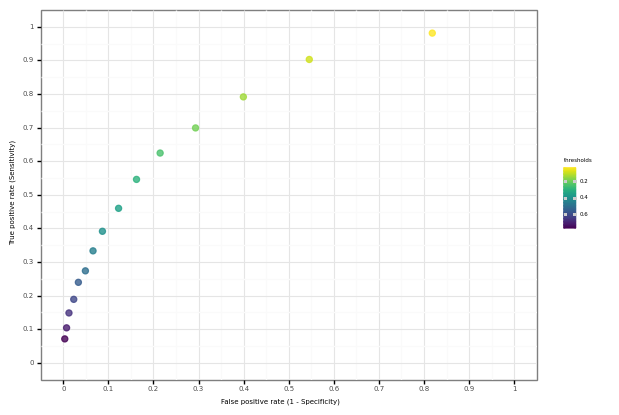

<ggplot: (140020653550)>

In [53]:
ggplot(tpr_fpr_for_thresholds, aes(x = 'false_positive_rates', y = 'true_positive_rates', color='thresholds'))\
        + labs(x = "False positive rate (1 - Specificity)", y = "True positive rate (Sensitivity)")\
        + geom_point(size=2, alpha=0.8) + scale_color_continuous(trans = 'reverse')\
        + scale_x_continuous(limits=(0,1), breaks = seq(0, 1.01, by = 0.1))\
        + scale_y_continuous(limits=(0,1), breaks = seq(0, 1.01, by = 0.1))\
        + theme_bw()\
        +theme(legend_position="right",
            axis_text=element_text(size=5),
            axis_title=element_text(size=5),
            legend_text = element_text(size = 4),
            legend_title = element_text(size = 4),
            legend_key_size=6)

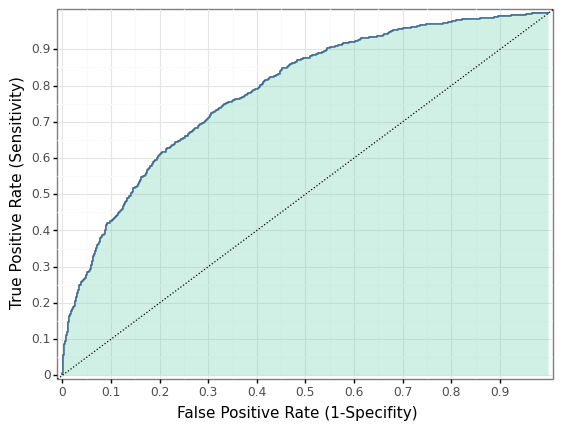

<ggplot: (140020647578)>

In [54]:
# continuous ROC on holdout with best model (Logit 4) -------------------------------------------

create_roc_plot(y_holdout, logit_predicted_probabilities_holdout)

In [55]:
# Confusion table with different tresholds ----------------------------------------------------------

# default: the threshold 0.5 is used to convert probabilities to binary classes
logit_class_prediction = best_model.predict(best_model_X_holdout)

values, counts = np.unique(logit_class_prediction.tolist(), return_counts=True)
print(values[0],' (no default): ',counts[0])
print(values[1],' (default): ',counts[1])

0  (no default):  3443
1  (default):  364


In [56]:
# confusion matrix: summarize different type of errors and successfully predicted cases
# positive = "yes": explicitly specify the positive case
cm_object1 = confusion_matrix(y_holdout, logit_class_prediction, labels=[0,1])
cm1 = pd.DataFrame(cm_object1, 
    index=['Actul no defaul', 'Actual default'], 
    columns=['Predicted no default', 'Predicted default'])
cm1

,Predicted no default,Predicted default
Actul no defaul,2869,148
Actual default,574,216


In [57]:
# we can apply different thresholds

# 0.5 same as before
holdout_prediction = np.where(logit_predicted_probabilities_holdout < 0.5, 0, 1)
cm_object1b = confusion_matrix(y_holdout, holdout_prediction, labels=[0,1])
cm1b = pd.DataFrame(cm_object1b, 
    index=['Actul no defaul', 'Actual default'], 
    columns=['Predicted no default', 'Predicted default'])
cm1b

,Predicted no default,Predicted default
Actul no defaul,2869,148
Actual default,574,216


In [58]:
# a sensible choice: mean of predicted probabilities
mean_predicted_default_prob = np.mean(logit_predicted_probabilities_holdout)
round(mean_predicted_default_prob, 3)

0.209

In [59]:
holdout_prediction = np.where(logit_predicted_probabilities_holdout < mean_predicted_default_prob, 0, 1)
cm_object2 = confusion_matrix(y_holdout, holdout_prediction, labels=[0,1])
cm2 = pd.DataFrame(cm_object2, 
    index=['Actul no defaul', 'Actual default'], 
    columns=['Predicted no default', 'Predicted default'])
cm2

,Predicted no default,Predicted default
Actul no defaul,2174,843
Actual default,248,542


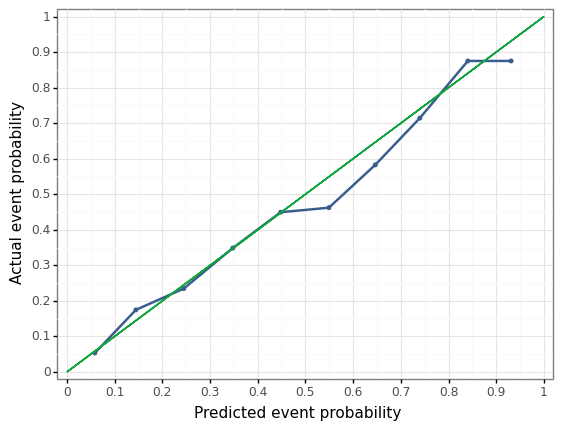

<ggplot: (140022376244)>

In [60]:
# Calibration curve -----------------------------------------------------------
# how well do estimated vs actual event probabilities relate to each other?

holdout = pd.concat([best_model_X_holdout, y_holdout], axis=1)
holdout["best_logit_no_loss_pred"] = logit_predicted_probabilities_holdout
create_calibration_plot(holdout, file_name = "ch17-figure-1-logit-m4-calibration",\
                        prob_var='best_logit_no_loss_pred', actual_var='default',\
                        y_lab="Actual event probability", n_bins=10, breaks=None)

# PART II.

# We have a loss function

In [61]:
# Introduce loss function
# relative cost of of a false negative classification (as compared with a false positive classification)
FP = 1
FN = 10
cost = FN/FP
# the prevalence, or the proportion of cases in the population (n.cases/(n.controls+n.cases))
prevelance = y_train.sum()/len(y_train)

In [62]:
# Draw ROC Curve and find optimal threshold with loss function --------------------------
# The optimal cut-off is the threshold that maximizes the distance to the identity (diagonal) line

best_thresholds_cv = dict()
expected_loss_cv = dict()
fold5_threshold = dict()
fold5_expected_loss = dict()
fold5_all_coords = dict()

for i, model_name in enumerate(logit_models):
    best_thresholds = []
    expected_loss =[]
    if model_name != 'LASSO':
        X = logit_model_vars[i]
        c_index = 0
    else:
        X = normalized_logitvars
        c_index = best_lambda_i
    fold = 0
    for train_index, test_index in k.split(X):
        X_fold = X.iloc[test_index,:]
        y_fold = y_train.iloc[test_index]
        pred_fold = generate_fold_prediction(logit_models[model_name], X_fold, fold, c_index)
        false_pos_rate, true_pos_rate, thresholds = roc_curve(y_fold, pred_fold)
        optimal_threshold = sorted(list(zip(
            np.abs(true_pos_rate + (1 - prevelance)/(cost * prevelance)*(1-false_pos_rate)),\
                                       thresholds)), key=lambda i: i[0], reverse=True)[0][1]
        best_thresholds.append(optimal_threshold)
        threshold_prediction = np.where(pred_fold < optimal_threshold, 0, 1)
        tn, fp, fn, tp = confusion_matrix(y_fold, threshold_prediction, labels=[0,1]).ravel()
        curr_exp_loss = (fp*FP + fn*FN)/len(y_fold)
        expected_loss.append(curr_exp_loss)
        fold = fold+1

    best_thresholds_cv[model_name] = np.mean(best_thresholds)
    expected_loss_cv[model_name] = np.mean(expected_loss)

    # for fold #5
    fold5_threshold[model_name] = optimal_threshold
    fold5_expected_loss[model_name] = curr_exp_loss

    all_coords = pd.DataFrame({
        'false_pos': false_pos_rate*sum(y_fold == 0),
        'true_pos': true_pos_rate*sum(y_fold == 1),
        'false_neg': sum(y_fold == 1) - true_pos_rate*sum(y_fold == 1),
        'true_neg': sum(y_fold == 0) - false_pos_rate*sum(y_fold == 0),
        'pos': sum(y_fold == 1),
        'neg': sum(y_fold == 0),
        'n': len(y_fold),
        'thresholds': thresholds
    })
    
    fold5_all_coords[model_name] = all_coords

In [63]:
logit_summary2 = pd.DataFrame(best_thresholds_cv.items(),columns=['Model', 'Avg of optimal thresholds'])
logit_summary2['Threshold for Fold5'] = fold5_threshold.values()
logit_summary2['Avg expected loss'] = expected_loss_cv.values()
logit_summary2['Expected loss for Fold5'] = fold5_expected_loss.values()

In [64]:
logit_summary2

,Model,Avg of optimal thresholds,Threshold for Fold5,Avg expected loss,Expected loss for Fold5
0,X1,0.082475,0.082683,0.727953,0.729721
1,X2,0.085205,0.084619,0.661632,0.648604
2,X3,0.086214,0.090212,0.630309,0.607882
3,X4,0.095881,0.095121,0.620722,0.591790
4,X5,0.100571,0.093599,0.623480,0.598686
5,LASSO,0.092846,0.096592,0.626894,0.596716


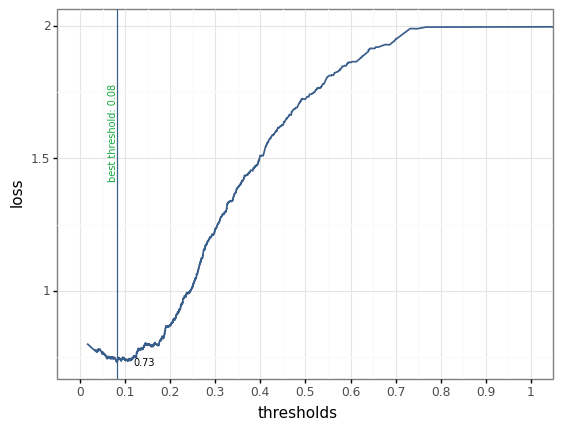

<ggplot: (140020606555)>

In [65]:
# Create loss plot based on Fold5 in CV ----------------------------------------------
# select model to plot
model_to_plot = 'X1'
create_loss_plot(fold5_all_coords[model_to_plot], fold5_threshold[model_to_plot], fold5_expected_loss[model_to_plot])

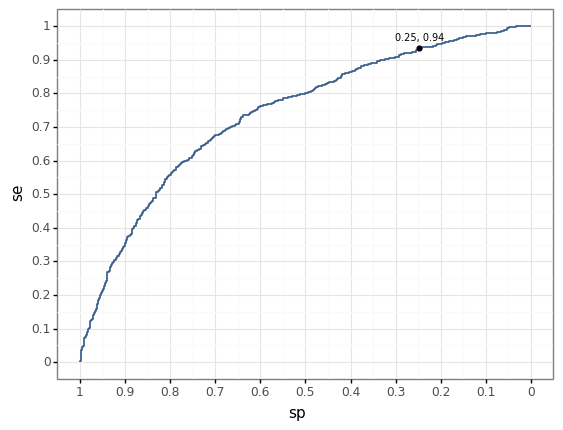

<ggplot: (140023898609)>

In [66]:
# Create roc plot plot based on Fold5 in CV ----------------------------------------------
# select model to plot
model_to_plot = 'X1'
create_roc_plot_with_optimal(fold5_all_coords[model_to_plot], fold5_threshold[model_to_plot])

In [67]:
# Pick best model based on average expected loss ----------------------------------
#X4
best_logit_optimal_treshold = best_thresholds_cv["X4"]

# Get expected loss on holdout
holdout_treshold = np.where(logit_predicted_probabilities_holdout < best_logit_optimal_treshold, 0, 1)
tn, fp, fn, tp = confusion_matrix(y_holdout, holdout_treshold, labels=[0,1]).ravel()
expected_loss_holdout = (fp*FP + fn*FN)/len(y_holdout)
round(expected_loss_holdout, 3)

0.634

In [68]:
cm_object3 = confusion_matrix(y_holdout, holdout_treshold, labels=[0,1])
cm3 = pd.DataFrame(cm_object3, 
    index=['Actul no defaul', 'Actual default'], 
    columns=['Predicted no default', 'Predicted default'])
cm3

,Predicted no default,Predicted default
Actul no defaul,1322,1695
Actual default,72,718


# PREDICTION WITH RANDOM FOREST

In [69]:
rfvars_train = rfvars.iloc[index_train]
rfvars_holdout = rfvars.iloc[index_holdout]

## Graph example

<Figure size 432x288 with 0 Axes>

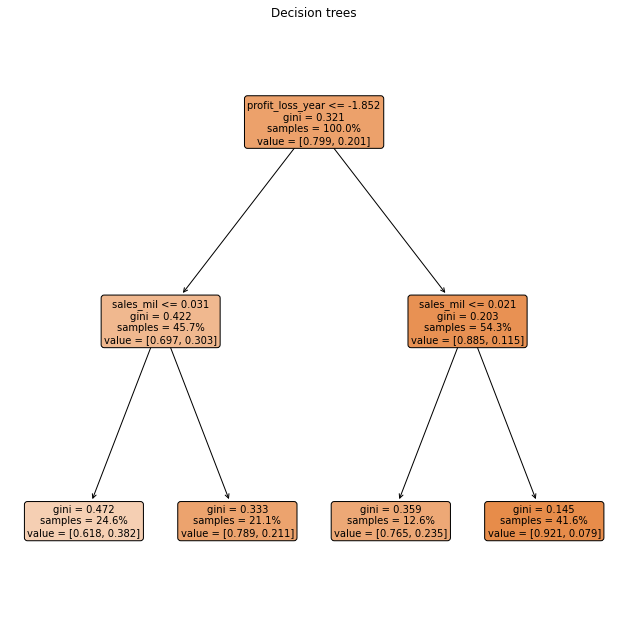

In [70]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.tree import plot_tree

data_for_graph = rfvars_train[['sales_mil','profit_loss_year','foreign_management']]
rf_for_graph = DecisionTreeClassifier(ccp_alpha=0.0028, min_samples_leaf=100, max_depth=3, random_state=41).fit(
    data_for_graph, y_train)

plt.figure()
plt.figure(figsize=(11,11))
plot_tree(rf_for_graph, 
          feature_names = data_for_graph.columns, filled=True, rounded=True, proportion=True, fontsize = 10)
plt.title("Decision trees")
plt.show() 

## Probability forest

Split by gini, ratio of 1's in each tree, average over trees

In [71]:
grid = {'max_features': [5, 6, 7],
        'criterion':['gini'],
        'min_samples_split': [11, 16]} #1 more than in R because here condition for min node size is >= while > in R 

In [72]:
prob_forest = RandomForestClassifier(random_state=42, n_estimators=500, oob_score=True)
prob_forest_grid = GridSearchCV(prob_forest, grid, cv=k, refit='accuracy',
                                scoring = ['accuracy', 'roc_auc', 'neg_brier_score'], n_jobs=-1)

In [73]:
prob_forest_fit = prob_forest_grid.fit(rfvars_train, y_train)

In [74]:
#create CV summary table
cv_accuracy = np.zeros([6])
for i in range(5):
    cv_accuracy = cv_accuracy + prob_forest_fit.cv_results_['split' + str(i) + '_test_accuracy']
cv_accuracy = cv_accuracy/5

cv_auc = np.zeros([6])
for i in range(5):
    cv_auc = cv_auc + prob_forest_fit.cv_results_['split' + str(i) + '_test_roc_auc']
cv_auc = cv_auc/5

cv_rmse = np.zeros([6])
for i in range(5):
    cv_rmse = cv_rmse +np.sqrt(-1*(prob_forest_fit.cv_results_['split' + str(i) + '_test_neg_brier_score'])).tolist()
cv_rmse = cv_rmse/5

prob_forest_cv_results = pd.DataFrame({
    'max_features': prob_forest_fit.cv_results_['param_max_features'],
    'min_samples_split': prob_forest_fit.cv_results_['param_min_samples_split'],
    'cv_accuracy': cv_accuracy,
    'cv_auc': cv_auc,
    'cv_rmse': cv_rmse
})

In [75]:
prob_forest_cv_results

,max_features,min_samples_split,cv_accuracy,cv_auc,cv_rmse
0,5,11,0.826121,0.809474,0.354195
1,5,16,0.825071,0.808592,0.354369
2,6,11,0.827369,0.808498,0.354138
3,6,16,0.827303,0.808903,0.354135
4,7,11,0.827303,0.809162,0.353927
5,7,16,0.826909,0.808927,0.354050


In [76]:
#obtain optimal parameter values
best_mtry = prob_forest_fit.best_params_['max_features']
best_min_node_size = prob_forest_fit.best_params_['min_samples_split']
prob_forest_fit.best_params_

{'criterion': 'gini', 'max_features': 6, 'min_samples_split': 11}

In [77]:
# Get average (ie over the folds) RMSE and AUC ------------------------------------
prob_forest_best_results = prob_forest_cv_results[(prob_forest_cv_results.max_features == best_mtry) & 
                      (prob_forest_cv_results.min_samples_split == best_min_node_size)]
prob_forest_best_results_index = prob_forest_best_results.index.values[0]

CV_RMSE['rf_p'] = prob_forest_best_results.cv_rmse.values[0]
CV_AUC['rf_p'] = prob_forest_best_results.cv_auc.values[0]

In [78]:
# Get fold level RMSE and AUC ------------------------------------

CV_RMSE_folds_rf_p = list()
for i in range(5):
    rmse = np.sqrt(-1*(prob_forest_fit.cv_results_['split' + str(i) + '_test_neg_brier_score'])).tolist()[prob_forest_best_results_index]
    CV_RMSE_folds_rf_p.append(rmse)
CV_RMSE_folds['rf_p'] = CV_RMSE_folds_rf_p

CV_AUC_folds_rf_p = list()
for i in range(5):
    rmse = prob_forest_fit.cv_results_['split' + str(i) + '_test_roc_auc'][prob_forest_best_results_index]
    CV_AUC_folds_rf_p.append(rmse)
CV_AUC_folds['rf_p'] = CV_AUC_folds_rf_p

In [79]:
# Now use loss function and search for best thresholds and expected loss over folds -----
best_thresholds = list()
expected_loss = list()

fold = 0
for train_index, test_index in k.split(rfvars_train):
    X_fold = rfvars_train.iloc[test_index,:]
    y_fold = y_train.iloc[test_index]
    
    X_fold_train = rfvars_train.iloc[train_index,:]
    y_fold_train = y_train.iloc[train_index]
    
    prob_forest_best = RandomForestClassifier(random_state=42, n_estimators=500, oob_score=True,
                    criterion = 'gini', max_features = best_mtry, min_samples_split = best_min_node_size)
    prob_forest_best_fold = prob_forest_best.fit(X_fold_train, y_fold_train)
    pred_fold = prob_forest_best_fold.predict_proba(X_fold)[:,1]

    false_pos_rate, true_pos_rate, threshold = roc_curve(y_fold, pred_fold)
    best_threshold = sorted(list(zip(np.abs(true_pos_rate + (1 - prevelance)/(cost * prevelance)*(1-false_pos_rate)),\
                                       threshold)), key=lambda x: x[0], reverse=True)[0][1]
    best_thresholds.append(best_threshold)
    threshold_prediction = np.where(pred_fold < best_threshold, 0, 1)
    tn, fp, fn, tp = confusion_matrix(y_fold, threshold_prediction, labels=[0,1]).ravel()
    curr_exp_loss = (fp*FP + fn*FN)/len(y_fold)
    expected_loss.append(curr_exp_loss)
    
fold5_threshold_rf = best_threshold
fold5_expected_loss_rf = curr_exp_loss

all_coords_rf = pd.DataFrame({
    'false_pos': false_pos_rate*sum(y_fold == 0),
    'true_pos': true_pos_rate*sum(y_fold == 1),
    'false_neg': sum(y_fold == 1) - true_pos_rate*sum(y_fold == 1),
    'true_neg': sum(y_fold == 0) - false_pos_rate*sum(y_fold == 0),
    'pos': sum(y_fold == 1),
    'neg': sum(y_fold == 0),
    'n': len(y_fold),
    'thresholds': threshold
})

In [80]:
fold5_threshold_rf = best_threshold
fold5_expected_loss_rf = curr_exp_loss

all_coords_rf = pd.DataFrame({
    'false_pos': false_pos_rate*sum(y_fold == 0),
    'true_pos': true_pos_rate*sum(y_fold == 1),
    'false_neg': sum(y_fold == 1) - true_pos_rate*sum(y_fold == 1),
    'true_neg': sum(y_fold == 0) - false_pos_rate*sum(y_fold == 0),
    'pos': sum(y_fold == 1),
    'neg': sum(y_fold == 0),
    'n': len(y_fold),
    'thresholds': threshold
})

In [81]:
expected_loss_cv['rf_p'] = np.mean(expected_loss)
best_thresholds_cv['rf_p'] = np.mean(best_thresholds)

In [82]:
rf_summary = pd.DataFrame(
    {'CV RMSE': [round(CV_RMSE['rf_p'], 3)],
     'CV AUC': [round(CV_AUC['rf_p'], 3)],
     'Avg of optimal thresholds': [round(best_thresholds_cv['rf_p'], 3)],
     'Threshold for Fold5': [round(best_threshold, 3)],
     'Avg expected loss': [round(expected_loss_cv['rf_p'], 3)],
     'Expected loss for Fold5': [round(curr_exp_loss, 3)]})

rf_summary

,CV RMSE,CV AUC,Avg of optimal thresholds,Threshold for Fold5,Avg expected loss,Expected loss for Fold5
0,0.354,0.808,0.113,0.142,0.577,0.583


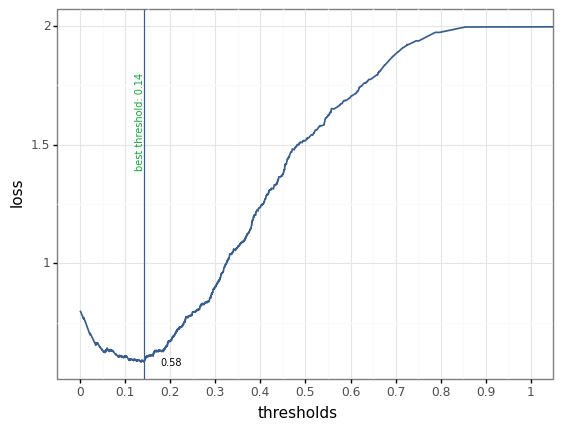

<ggplot: (140031977060)>

In [83]:
# Create plots based on Fold5 in CV ----------------------------------------------
create_loss_plot(all_coords_rf, fold5_threshold_rf, fold5_expected_loss_rf)

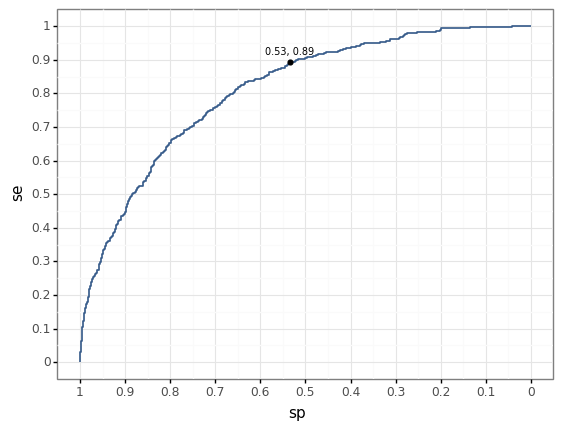

<ggplot: (140032050914)>

In [84]:
create_roc_plot_with_optimal(all_coords_rf, fold5_threshold_rf)

In [85]:
# Take model to holdout and estimate RMSE, AUC and expected loss ------------------------------------
prob_forest_fit_best = prob_forest_fit.best_estimator_
rf_predicted_probabilities_holdout = prob_forest_fit_best.predict_proba(rfvars_holdout)[:,1]
rmse_rf = np.sqrt(mean_squared_error(y_holdout, rf_predicted_probabilities_holdout))
round(rmse_rf, 3)

0.357

In [86]:
# ROC AUC  on holdout
auc_rf = roc_auc_score(y_holdout, rf_predicted_probabilities_holdout)
round(auc_rf, 3)

0.807

In [87]:
# Get expected loss on holdout
holdout_treshold = np.where(rf_predicted_probabilities_holdout < best_thresholds_cv['rf_p'], 0, 1)
tn, fp, fn, tp = confusion_matrix(y_holdout, holdout_treshold, labels=[0,1]).ravel()
expected_loss_holdout = (fp*FP + fn*FN)/len(y_holdout)
round(expected_loss_holdout, 3)

0.614

## Classification forest

Split by Gini, majority vote in each tree, majority vote over trees

Show expected loss with classification RF and default majority voting to compare

In [88]:
#currently no method implemented in python for this

## Final results

In [89]:
#Note: in R length(rfvars) counts 1 for category variables (39), here they count category number-1 (44)
nvars['rf_p'] = len(rfvars.columns)

In [90]:
summary_results = pd.DataFrame({"Model": list(nvars.keys()),
                              "Number of predictors": list(nvars.values()),
                              "CV RMSE": list(CV_RMSE.values()),
                              "CV AUC": list(CV_AUC.values()),
                              "CV threshold": list(best_thresholds_cv.values()),
                              "CV expected Loss": list(expected_loss_cv.values())
                               })

In [91]:
summary_results

,Model,Number of predictors,CV RMSE,CV AUC,CV threshold,CV expected Loss
0,X1,11,0.374183,0.736470,0.082475,0.727953
1,X2,18,0.365753,0.770553,0.085205,0.661632
2,X3,35,0.364340,0.778596,0.086214,0.630309
3,X4,79,0.361610,0.784990,0.095881,0.620722
4,X5,153,0.361174,0.786255,0.100571,0.623480
5,LASSO,120,0.360821,0.786736,0.092846,0.626894
6,rf_p,44,0.354138,0.808498,0.112693,0.577320


In [92]:
data

,year,comp_id,begin,end,amort,curr_assets,curr_liab,extra_exp,extra_inc,extra_profit_loss,...,flag_miss_ceo_age,ceo_young,labor_avg_mod,flag_miss_labor_avg,default_f,sales_mil_log_sq,flag_low_d1_sales_mil_log,flag_high_d1_sales_mil_log,d1_sales_mil_log_mod,d1_sales_mil_log_mod_sq
0,2012,1.001541e+06,2012-01-01,2012-12-31,481.481476,9.629630e+03,1.303704e+03,0.000000,0.000000,0.000000,...,0,1,0.621691,1,no_default,45.190017,1,0,-1.500000,2.250000
1,2012,1.002029e+06,2012-01-01,2012-12-31,14929.629883,2.038852e+05,1.204445e+05,0.000000,0.000000,0.000000,...,0,1,0.458333,0,no_default,0.016375,0,0,0.684448,0.468469
2,2012,1.003200e+06,2012-01-01,2012-12-31,25.925926,2.222222e+01,1.099630e+04,0.000000,0.000000,0.000000,...,1,0,0.621691,1,default,34.614876,0,0,-1.424773,2.029978
3,2012,1.011889e+06,2012-01-01,2012-12-31,36625.925781,1.601667e+05,1.891111e+04,0.000000,0.000000,0.000000,...,0,0,1.621212,0,no_default,0.698025,0,0,0.097722,0.009550
4,2012,1.014183e+06,2012-01-01,2012-12-31,12551.851562,1.999037e+05,8.274074e+03,0.000000,7.407407,7.407407,...,0,0,0.715278,0,no_default,4.171000,0,0,-0.273087,0.074577
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
19031,2012,4.638739e+11,2012-01-01,2012-12-31,40.740742,1.534444e+04,4.840741e+03,0.000000,3703.703613,3703.703613,...,1,0,0.250000,0,no_default,11.206805,0,0,0.000000,0.000000
19032,2012,4.639820e+11,2012-01-01,2012-12-31,16337.037109,3.140000e+04,8.300000e+03,0.000000,0.000000,0.000000,...,0,0,0.548611,0,no_default,2.743576,0,0,-0.844769,0.713634
19033,2012,4.640212e+11,2012-01-01,2012-12-31,3566.666748,3.149630e+04,1.783704e+04,0.000000,0.000000,0.000000,...,1,0,0.083333,0,no_default,10.685726,0,0,-0.282607,0.079867
19034,2012,4.640446e+11,2012-01-01,2012-12-31,76059.257812,4.776548e+06,1.297552e+06,0.000000,0.000000,0.000000,...,1,0,1.840278,0,no_default,4.596972,0,0,0.294490,0.086725
